# **Laboratorio 2 - SIS421** 

**MLP con Pytorch**

Seguire varios pasos del archivo con la receta de para entrenar Redes Neuronales

Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación

Para el laboratorio se hara el uso de 10000 imagenes como solicita el enunciado

Se usara 2000 imagenes por cada planta, en las que se uso data aumentation

Las 5 plantas medicinales seleccionadas son:
Coca
Eucalipto
Guanabana
Lengua de Suegra
Manzanilla

In [50]:
#Importamos las librerias necesarias para el MLP
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

Para el MLP hare uso de mi GPU propia asi que nos aseguramos que CUDA este instalado correctamente

In [51]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible. Usando GPU.")
else:
    device = torch.device("cpu")
    print("GPU no disponible. Usando CPU.")

GPU disponible. Usando GPU.


## **Exploración de Datos**

In [52]:
#Definimos las rutas de las carpetas donde se encuentran nuestras imagenes
root_dir = r"E:\LAB2SIS421\DATASETPLANTAS"
classes = ['COCA', 'EUCALIPTO', 'GUANABANA', 'LENGUA DE SUEGRA', 'MANZANILLA']

#Creamos una funcion para cargar y redimensionar las imagene
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((256, 256))  # Redimensionamos las imágenes
        images.append(np.array(img))
        labels.append(label)
    return images, labels

#Cargamos las imágenes y etiquetas en un dataset
images = []
labels = []

for idx, class_name in enumerate(classes):
    folder_path = os.path.join(root_dir, class_name)
    class_images, class_labels = load_images_from_folder(folder_path, idx)
    images.extend(class_images)
    labels.extend(class_labels)
    
#Convertimos a un array numpy 
images = np.array(images)
labels = np.array(labels)


100%|██████████| 2000/2000 [00:10<00:00, 185.66it/s]


In [53]:
#Dividimos el dataset en 80% entrenamiento y 20% testeo
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [54]:
#Información del dataset
print("Número de imágenes de entrenamiento:", len(train_images))
print("Número de imágenes de testeo:", len(test_images))
print("Resolución y número de canales:", train_images.shape[1:], test_images.shape[1:])

Número de imágenes de entrenamiento: 8000
Número de imágenes de testeo: 2000
Resolución y número de canales: (256, 256, 3) (256, 256, 3)


In [55]:
#Estadísticas del dataset
max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

print("Valor máximo por canal:", max_value)
print("Valor mínimo por canal:", min_value)

Valor máximo por canal: [255 255 255]
Valor mínimo por canal: [0 0 0]


In [56]:
#La media y Desviación estándar
#Lo calcularemos de manera incremental para evitar sobrecargar el disco y la memoria
def calculate_mean_std(images):
    n_images, h, w, c = images.shape
    mean = np.zeros(c)
    std = np.zeros(c)
    
    for img in tqdm(images):
        mean += img.mean(axis=(0, 1)) / 255.0
    
    mean /= n_images

    for img in tqdm(images):
        std += ((img / 255.0 - mean) ** 2).sum(axis=(0, 1))

    std = np.sqrt(std / (n_images * h * w))

    return mean, std

mean, std = calculate_mean_std(train_images)

print("Media por canal:", mean)
print("Desviación estándar por canal:", std)


100%|██████████| 8000/8000 [00:10<00:00, 782.92it/s]

Media por canal: [0.35620844 0.3539975  0.29395614]
Desviación estándar por canal: [0.23790159 0.23207164 0.21248161]


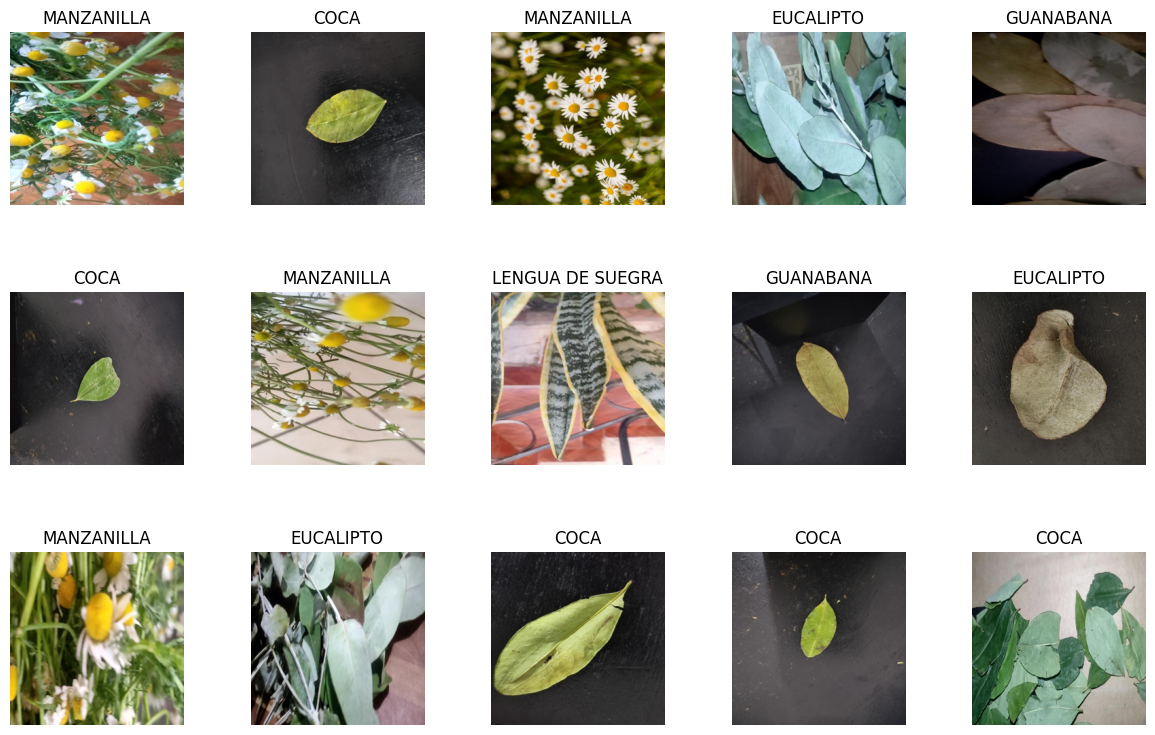

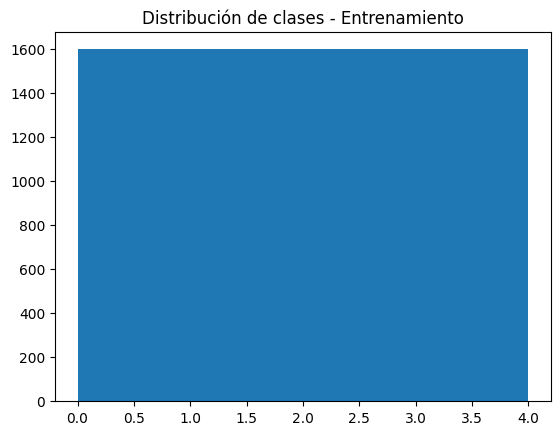

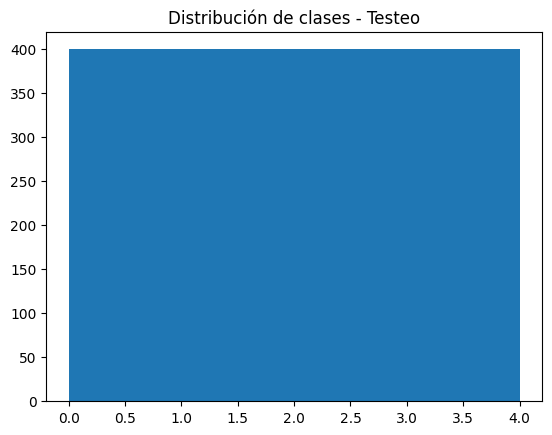

Distribución de clases en entrenamiento: {0: 1600, 1: 1600, 2: 1600, 3: 1600, 4: 1600}
Distribución de clases en testeo: {0: 400, 1: 400, 2: 400, 3: 400, 4: 400}


In [57]:
#Visualización de imagenes
r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = np.random.randint(0, len(train_images))
        img, label = train_images[ix], train_labels[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Distribución de clases en el dataset de entrenamiento
plt.hist(train_labels, bins=len(classes))
plt.title('Distribución de clases - Entrenamiento')
plt.show()

# Distribución de clases en el dataset de testeo
plt.hist(test_labels, bins=len(classes))
plt.title('Distribución de clases - Testeo')
plt.show()

# Conteo de clases
unique_train, counts_train = np.unique(train_labels, return_counts=True)
print("Distribución de clases en entrenamiento:", dict(zip(unique_train, counts_train)))

unique_test, counts_test = np.unique(test_labels, return_counts=True)
print("Distribución de clases en testeo:", dict(zip(unique_test, counts_test)))

Como se ve tenemos 5 clases distribuidas correctamente entre el entrenamiento y la prueba

## **Validar la red neuronal**

In [58]:
# Definimos el modelo ajustado a la resolución de las imágenes
def build_model(D_in=256*256*3, H=100, D_out=len(classes)):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [59]:
# Construimos y probamos el modelo
model = build_model()
test_input = torch.randn((64, 256*256*3)).cuda() 
test_output = model(test_input)
print("Output shape:", test_output.shape)

Output shape: torch.Size([64, 5])


Con los datos de salida podemos ver que coinciden correctamente con lo esperado

## **Fit de una Muestra**

In [60]:
# Preparación de los subconjuntos de datos
X_train, X_val, X_subset = train_images[:8000], train_images[8000:], train_images[:2000]
y_train, y_val, y_subset = train_labels[:8000], train_labels[8000:], train_labels[:2000]

X_train.shape, X_val.shape, X_subset.shape

((8000, 256, 256, 3), (0, 256, 256, 3), (2000, 256, 256, 3))

Definimos el dataset adaptado a la resolución

In [61]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 256*256*3) 
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [62]:
# Fit de la primera imagen del dataset
dataset = Dataset(X_subset[:1], y_subset[:1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

len(dataset)

1

Probamos el modelo con 5 epochs y probando solo con una clase para ver que funcione correctamente

In [63]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
model = build_model(D_in=256*256*3, D_out=len(classes))  # Adaptamos al tamaño de las imágenes
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")

Epoch 1/5 loss 1.59132 y 0 y_pred 2
Epoch 2/5 loss 0.00000 y 0 y_pred 0
Epoch 3/5 loss 0.00000 y 0 y_pred 0
Epoch 4/5 loss 0.00000 y 0 y_pred 0
Epoch 5/5 loss 0.00000 y 0 y_pred 0


## **Fit de un Batch**

Definimos el Dataset pero limitando a un batch de 64 para hacer la prueba

In [64]:
dataset = Dataset(X_subset[:64], y_subset[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

Probamos el modelo de nuevo pero con 200epochs con el batch definido para ver que funcione correctamente

In [65]:
epochs = 200
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/200 loss 6.75665 acc 22/64
Epoch 20/200 loss 1.33049 acc 28/64
Epoch 30/200 loss 0.62143 acc 45/64
Epoch 40/200 loss 0.33090 acc 58/64
Epoch 50/200 loss 0.24901 acc 60/64
Epoch 60/200 loss 0.16868 acc 62/64
Epoch 70/200 loss 0.13185 acc 63/64
Epoch 80/200 loss 0.10247 acc 64/64
Epoch 90/200 loss 0.08156 acc 64/64
Epoch 100/200 loss 0.06612 acc 64/64
Epoch 110/200 loss 0.05427 acc 64/64
Epoch 120/200 loss 0.04511 acc 64/64
Epoch 130/200 loss 0.03796 acc 64/64
Epoch 140/200 loss 0.03233 acc 64/64
Epoch 150/200 loss 0.02784 acc 64/64
Epoch 160/200 loss 0.02421 acc 64/64
Epoch 170/200 loss 0.02125 acc 64/64
Epoch 180/200 loss 0.01881 acc 64/64
Epoch 190/200 loss 0.01677 acc 64/64
Epoch 200/200 loss 0.01505 acc 64/64


## **Batch Size**

Para esto volveremos a cargar el dataset usando transform para evitar sobrecargar la memoria

Probando batch size 16
Probando batch size 32
Probando batch size 64


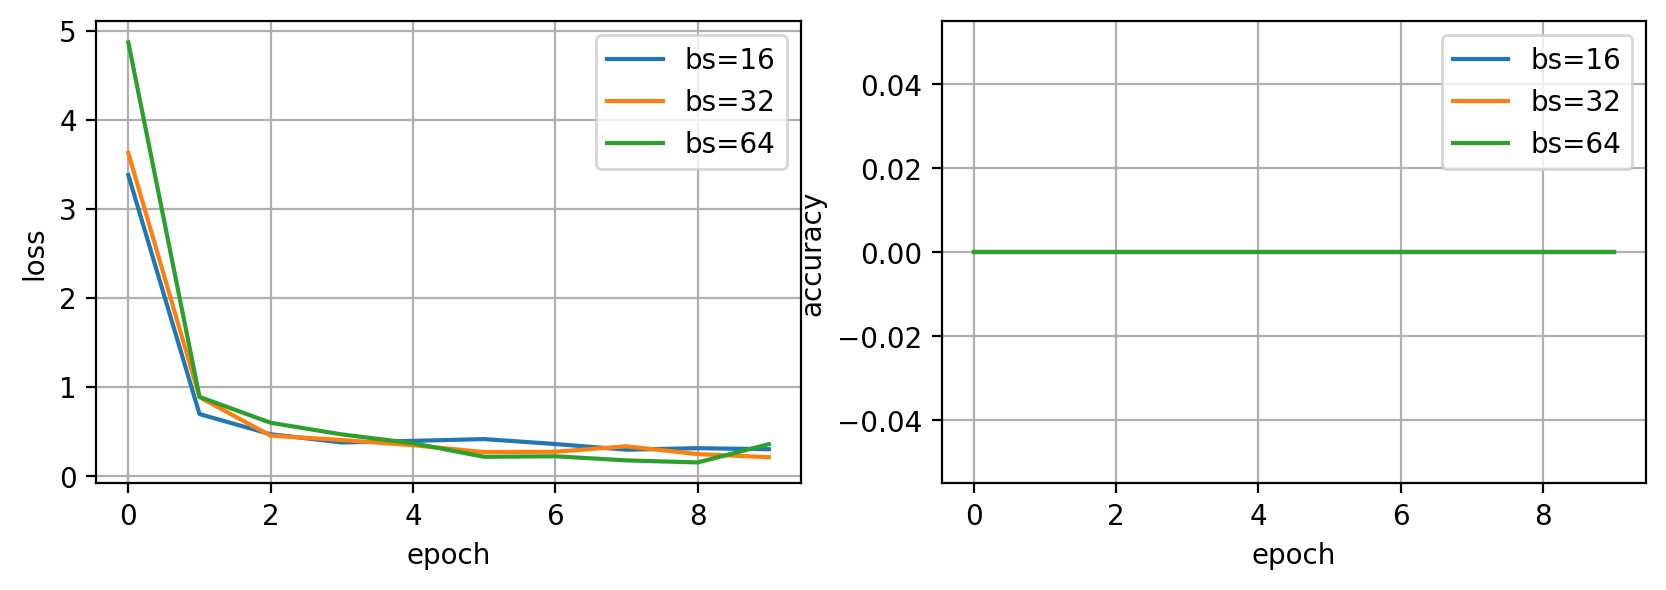

In [66]:
#Definir las transformaciones para reducir el tamaño y normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y.astype(np.int64)  #Convertir las etiquetas a enteros de 64 bits
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = Image.fromarray(self.X[ix].astype('uint8'), 'RGB')
        label = self.Y[ix]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long).cuda() 

#Preparar los subconjuntos de datos usando DataLoader con las transformaciones
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)

#Definiremos los Batch Size que queramos probar
bss = [16, 32, 64]
hists = []

for bs in bss:
    print(f"Probando batch size {bs}")
    dataloader = {
        'train': DataLoader(train_dataset, batch_size=bs, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=1000, shuffle=False)
    }
    model = build_model(D_in=256*256*3, D_out=len(classes))  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    hist = {'loss': [], 'val_acc': []}

    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(10):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b.view(x_b.size(0), -1).cuda())
            loss = criterion(y_pred, y_b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (y_b == torch.argmax(y_pred, axis=1)).sum().item()
            total += y_b.size(0)
        
        hist['loss'].append(epoch_loss / len(dataloader['train']))
        
        #Validación
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_val, y_val in dataloader['val']:
                y_val_pred = model(x_val.view(x_val.size(0), -1).cuda())
                val_correct += (y_val == torch.argmax(y_val_pred, axis=1)).sum().item()
                val_total += y_val.size(0)
        
        #Evitar la división por cero
        if val_total > 0:
            hist['val_acc'].append(val_correct / val_total)
        else:
            hist['val_acc'].append(0)  #En caso de que no haya datos de validación
        
    hists.append(hist)

#Visualización de resultados
fig = plt.figure(dpi=200, figsize=(10, 3))

ax = plt.subplot(121)
for i in range(len(bss)):
    ax.plot(hists[i]['loss'], label=f"bs={bss[i]}")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax = plt.subplot(122)
for i in range(len(bss)):
    ax.plot(hists[i]['val_acc'], label=f"bs={bss[i]}")
ax.legend()
ax.grid(True)
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')

plt.show()


En este caso mi gpu soporto los batch size, ademas de que en tienen muy poca diferencia los batches probados

## **Entrenamiento**

Luego de haber probado por muestras y batches vemos que nuestro modelo nos funciona correctamente, asi que ahora haremos el entrenamiento con todas las imagenes

In [67]:
#Definimos las transformaciones para escalar y normalizar, para no sobrecargar la memoria
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Creamos una clase personalizada para este entrenamiento
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.images = []
        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append((img_path, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

#Crearemos el dataset usando la ruta donde se encuentran las imagenes
dataset = PlantDataset(root_dir='E:\LAB2SIS421\DATASETPLANTAS', transform=transform)

In [68]:
#Dividimos el dataset en 80% train y 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Crear los DataLoader con batch_size de 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
#Crearemos una carpeta donde se guardaran los checkpoints
checkpoint_dir = 'checkpointsLab2BP'
os.makedirs(checkpoint_dir, exist_ok=True)

#Definimos el modelo con Batch Normalizacion y Dropout
def build_model(D_in=256*256*3, H=100, D_out=5): #H representa las unidades de neuronas el minimo solicitado fue de 50 pero en mi caso usare 100
    return nn.Sequential(
        nn.Linear(D_in, H),
        nn.BatchNorm1d(H),
        nn.ReLU(),
        nn.Dropout(0.5),  #Dropout con probabilidad de 0.5
        nn.Linear(H, H),
        nn.BatchNorm1d(H),
        nn.ReLU(),
        nn.Dropout(0.5),  #Dropout con probabilidad de 0.5
        nn.Linear(H, D_out)
    ).cuda()

#Inicializamos el modelo, criterio y optimizador
model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
#Función para guardar el checkpoint
def save_checkpoint(epoch, model, optimizer, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, path)

#Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


In [71]:
# Almacenar valores de cada epoch para poder graficarlos y ver como mejoro el entrenamiento
hist = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

#Como fue solicitado se hara el entrenamiento con 1000epoch 
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda() #Aqui cargaremos las imagenes a CUDA para el uso de la GPU

        optimizer.zero_grad()
        outputs = model(images.view(images.size(0), -1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += calculate_accuracy(outputs, labels) * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    #Evaluación en el conjunto de validación
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.cuda(), val_labels.cuda()
            val_outputs = model(val_images.view(val_images.size(0), -1))
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            val_running_corrects += calculate_accuracy(val_outputs, val_labels) * val_images.size(0)

    val_loss = val_running_loss / len(test_loader.dataset)
    val_acc = val_running_corrects / len(test_loader.dataset)

    # Guardar estadísticas en los hists
    hist['epoch'].append(epoch + 1)
    hist['loss'].append(epoch_loss)
    hist['acc'].append(epoch_acc)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)

    # Obtener la tasa de aprendizaje en este caso 0.001
    lr = optimizer.param_groups[0]['lr']

    # Guardar checkpoints cada 20 epoch como fue solicitado
    if (epoch + 1) % 20 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        save_checkpoint(epoch, model, optimizer, epoch_loss, checkpoint_path)
    #Imprimimos los datos recolectados de cada epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] loss {epoch_loss:.5f} acc {epoch_acc:.5f} val_loss {val_loss:.5f} val_acc {val_acc:.5f} lr {lr:.5f}')



Epoch [1/1000] loss 0.03601 acc 0.51425 val_loss 0.02595 val_acc 0.69700 lr 0.00100
Epoch [2/1000] loss 0.02586 acc 0.67763 val_loss 0.02051 val_acc 0.75650 lr 0.00100
Epoch [3/1000] loss 0.02171 acc 0.74713 val_loss 0.02276 val_acc 0.71350 lr 0.00100
Epoch [4/1000] loss 0.01950 acc 0.77687 val_loss 0.01330 val_acc 0.87100 lr 0.00100
Epoch [5/1000] loss 0.01791 acc 0.79312 val_loss 0.01534 val_acc 0.81950 lr 0.00100
Epoch [6/1000] loss 0.01590 acc 0.82212 val_loss 0.01150 val_acc 0.87600 lr 0.00100
Epoch [7/1000] loss 0.01439 acc 0.84262 val_loss 0.01113 val_acc 0.88250 lr 0.00100
Epoch [8/1000] loss 0.01406 acc 0.84450 val_loss 0.01322 val_acc 0.83800 lr 0.00100
Epoch [9/1000] loss 0.01306 acc 0.85600 val_loss 0.01084 val_acc 0.87450 lr 0.00100
Epoch [10/1000] loss 0.01268 acc 0.85850 val_loss 0.01062 val_acc 0.88450 lr 0.00100
Epoch [11/1000] loss 0.01236 acc 0.86113 val_loss 0.00948 val_acc 0.89650 lr 0.00100
Epoch [12/1000] loss 0.01198 acc 0.86362 val_loss 0.01050 val_acc 0.88500 

Graficaremos los valores recolectados en los hists

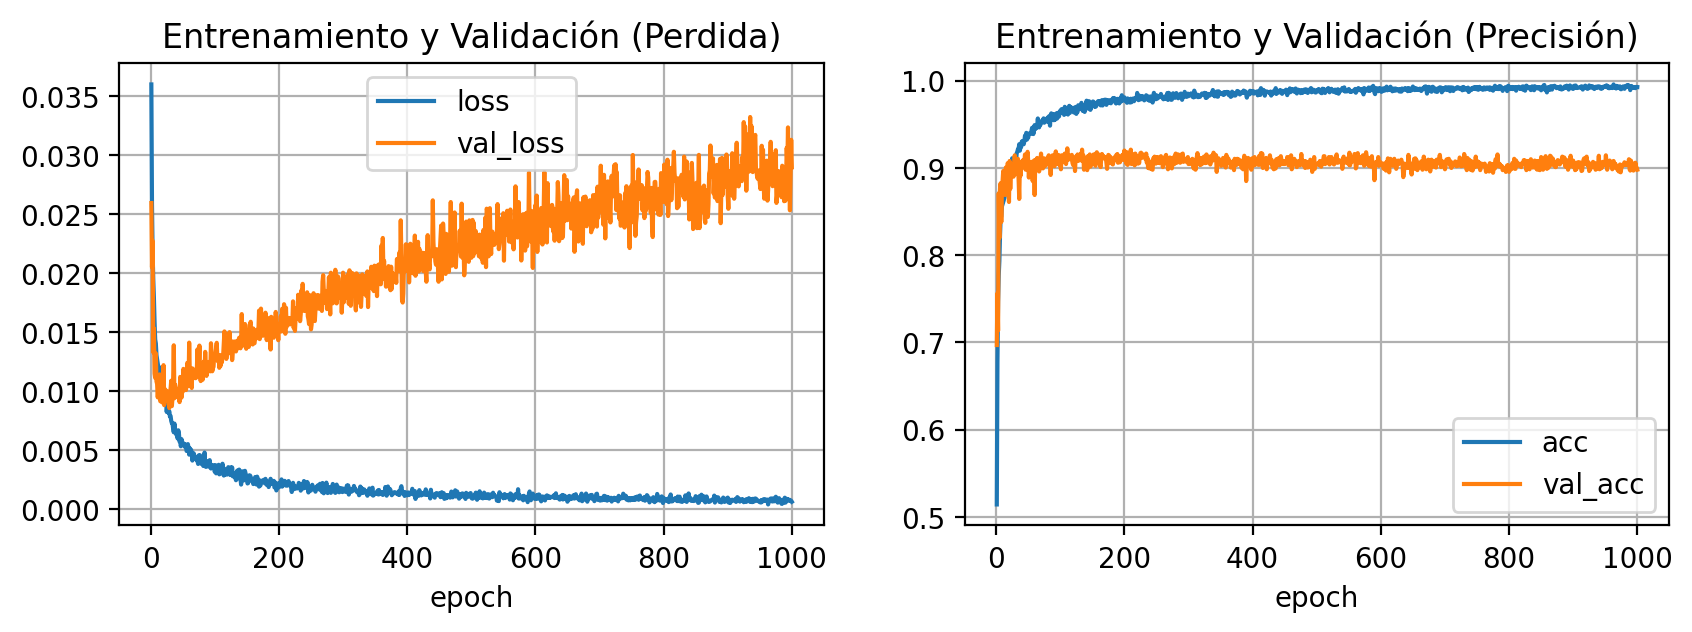

In [72]:
#Crear gráficas con pandas y matplotlib
fig = plt.figure(dpi=200, figsize=(10, 3))

#Gráfico de pérdida
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax.set_title("Entrenamiento y Validación (Perdida)")

#Gráfico de precisión
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax.set_title("Entrenamiento y Validación (Precisión)")

plt.show()

**Exportación y Evaluación**

In [73]:
#Haremos la exportación a torchscript
model_scripted = torch.jit.script(model)
model_scripted.save("Model_TorchLab2BP.pt")

#Haremos la exportación a ONNX
dummy_input = torch.randn(1, 3, 256, 256).cuda()  # Entrada simulada en GPU
dummy_input_flattened = dummy_input.view(1, -1)  # Aplanar el tensor a [1, 196608]
torch.onnx.export(model, dummy_input_flattened, "Model_ONNXLab2BP.onnx", input_names=['input'], output_names=['output'])


Ahora podremos importar el modelo ya entrenado a cualquier lugar

In [77]:
#Evaluación del modelo entrenado
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Mover los datos a la GPU
        images, labels = images.cuda(), labels.cuda()
        # Aplanar las imágenes
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.2f}%')


Precisión del modelo en el conjunto de prueba: 89.80%


Luego de horas de haber entrenado el modelo, obtuvimos una buena precisión 
Por la precicsion podemos ver que elegimos correctamente los hiperparametros para el entrenamiento

**Prueba de ONNX**

Haremos la prueba del modelo exportado en ONNX

In [83]:
import onnxruntime as ort

#Transformaciones para cargar el dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Cargar el modelo ONNX exportado antes
session = ort.InferenceSession('Model_ONNXLab2BP.onnx')

#Funcion para hacer las predicciones
def predict(image_path):
    #Cargar y transformar las imagenes
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0) 

    image = image.numpy()

    image = image.reshape(1, -1)

    inputs = {session.get_inputs()[0].name: image}
    outputs = session.run(None, inputs)
    prediction = np.argmax(outputs[0], axis=1)

    return prediction[0]

#Ejemplo
image_path = "E:\LAB2SIS421\DATASETPLANTAS\LENGUA DE SUEGRA\LENGUADESUEGRA123.jpg"
predicted_class = predict(image_path)
print(f'La clase predecida es: {predicted_class}')


La clase predecida es: 3


Como vemos la prediccion coincide correctamente con la imagen que queremos predecir